# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откроем файл с данными и изучим общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()
print(data)
data.describe()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


### Вывод

1. Предоставлены данные о продаже 23699 квартир за 2014 -2019 год.
2. По каждой квартире представлено 22 параметра.
3. В 14 параметрах имеются пропуски.

### Шаг 2. Предобработка данных

In [2]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

data.dropna(subset=['floors_total'], inplace=True)

data.loc[data.loc[:, 'living_area'].isnull()]
def mediana_living_area(quantity):
    x = data.query('rooms == @quantity')
    med = (x['living_area'] / x['total_area']).median()
    data['living_area'] = data['living_area'].fillna(data['total_area'] * med)
for row in data['rooms'].unique():
    mediana_living_area(row)
data['is_apartment'] = data['is_apartment'].fillna(False)

unliving_area = data['total_area'] - data['living_area']
part_kitchen_area = (data['kitchen_area'] / (unliving_area)).median()
data['kitchen_area'] = data['kitchen_area'].fillna(unliving_area * part_kitchen_area)

data['balcony'] = data['balcony'].fillna(0)

data['parks_around3000'] = data['parks_around3000'].fillna(0)

data['ponds_around3000'] = data['ponds_around3000'].fillna(0)


data['locality_name'] = data['locality_name'].str.lower()
data['floors_total'] = data['floors_total'].astype(int)
data['balcony'] = data['balcony'].astype(int)
data['parks_around3000'] = data['parks_around3000'].astype(int)
data['ponds_around3000'] = data['ponds_around3000'].astype(int)
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S')


data.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23613 non-null int64
last_price              23613 non-null float64
total_area              23613 non-null float64
first_day_exposition    23613 non-null datetime64[ns]
rooms                   23613 non-null int64
ceiling_height          23613 non-null float64
floors_total            23613 non-null int64
living_area             23613 non-null float64
floor                   23613 non-null int64
is_apartment            23613 non-null bool
studio                  23613 non-null bool
open_plan               23613 non-null bool
kitchen_area            23613 non-null float64
balcony                 23613 non-null int64
locality_name           23565 non-null object
airports_nearest        18081 non-null float64
cityCenters_nearest     18104 non-null float64
parks_around3000        23613 non-null int64
parks_nearest           8045 non-null float64
ponds_around30

### Вывод

1. Пропуски в колонке "Высота потолков" заменены медианным значением, т.к. если продавец не указывает высоту потолков, значит она стандартная.
2. Пропуски в столбце "Всего этажей в доме" удалены, т.к. их всего 86 штук.
3. Пропуски в столбце "Жилая площадь" заменены на медианные значения относительно количества комнат в квартире.
4. Проруски в столбце "Площадь кухни" заменены на медианные значения, вычисленные с помощью отношения площади кухний к нежилой площади.
5. Пропуски в столбцах "Количество балконов",  "Число парков в радиусе 3 км", "Число водоемов в радиусе 3 км" заменены на 0, т.к. скорее всего, их нет.
6. Пропуски в столбце "Населенный пункт" оставлены без изменения.
7. Пропуски в столбце "Расстояние до центра" оставлены без изменения.
8. Пропуски в столбце "Количество дней объявления" оставлены без изменения.
9. Пропуски в столбцах "Расстояние до парка", "Расстояние до водоема "оставлены без изменения, т.к. они относятся к значением 0 по количеству парков и водоемов.
10. Названия населенных пунктов приведены к нижнему регистру, чтобы не было повторений.
11. Тип данных столбца "Всего этажей в доме", "Количество балконов",  "Число парков в радиусе 3 км", "Число водоемов в радиусе 3 км" переведены из вещественного в целочисленный методом astype().
12. Тип данных даты публикации переведен из object в datetime


### Шаг 3. Посчитайте и добавьте в таблицу

In [3]:
data['price_m2'] = data['last_price'] / data['total_area']

In [4]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

In [5]:
def grouping_floor(data):
    floors_total = data['floors_total']
    floor = data['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'
data['grouping_floor'] = data.apply(grouping_floor, axis=1)

In [6]:
data['ratio_living_total'] = data['living_area'] / data['total_area']
data['ratio_kitchen_total'] = data['kitchen_area'] / data['total_area']
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_m2,weekday,month,year,grouping_floor,ratio_living_total,ratio_kitchen_total
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.000000,8,False,...,2,755.0,NaN,120370.370370,3,3,2019,другой,0.472222,0.231481
1,7,3350000.0,40.40,2018-12-04,1,2.65,11,18.600000,1,False,...,0,NaN,81.0,82920.792079,1,12,2018,первый,0.460396,0.272277
2,10,5196000.0,56.00,2015-08-20,2,2.65,5,34.300000,4,False,...,2,574.0,558.0,92785.714286,3,8,2015,другой,0.612500,0.148214
3,0,64900000.0,159.00,2015-07-24,3,2.65,14,100.461415,9,False,...,3,234.0,424.0,408176.100629,4,7,2015,другой,0.631833,0.151598
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.000000,13,False,...,1,48.0,121.0,100000.000000,1,6,2018,другой,0.320000,0.410000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5,73.300000,3,False,...,3,381.0,NaN,72490.845228,1,3,2017,другой,0.547792,0.103356
23695,14,3100000.0,59.00,2018-01-15,3,2.65,5,38.000000,4,False,...,0,NaN,45.0,52542.372881,0,1,2018,другой,0.644068,0.144068
23696,18,2500000.0,56.70,2018-02-11,2,2.65,3,29.700000,1,False,...,0,NaN,NaN,44091.710758,6,2,2018,первый,0.523810,0.196078
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17,48.493167,12,False,...,3,196.0,602.0,149511.400651,1,3,2017,другой,0.631833,0.303583


### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

count    23613.000000
mean        60.340678
std         35.648988
min         12.000000
25%         40.000000
50%         52.000000
75%         69.800000
max        900.000000
Name: total_area, dtype: float64
45.00     419
42.00     383
60.00     347
31.00     346
44.00     345
         ... 
226.00      1
51.17       1
44.84       1
78.61       1
14.00       1
Name: total_area, Length: 2160, dtype: int64


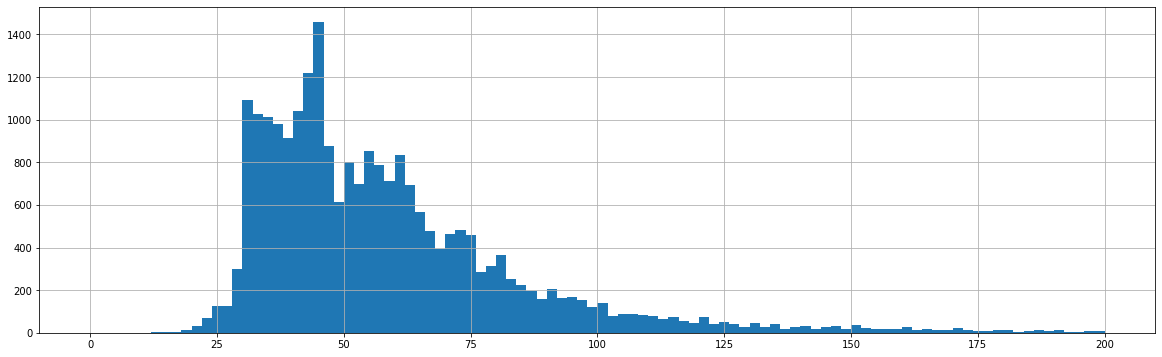

In [7]:
print(data['total_area'].describe())
print(data['total_area'].value_counts())
data['total_area'].hist(bins=100, range=(0, 200), figsize=(20, 6));

### Вывод

1. Площадь квартир варьируется от 12 м2 до 900 м2.
2. Самой популярной площадью является 45 м2.
3. Большинство цен находится в диапазоне от 40 до 69,8 м2 с медианой в 52 м2.
4. По гистограмме видно, что очень мало значений до 25 м2 и после 125 м2, есть отдельные выбросы вплоть до 900 м2. Основной пик приходится на диапазон от 30 до 45 м2.


count    2.361300e+04
mean     6.540555e+06
std      1.090172e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64
4500000.0     341
3500000.0     291
4300000.0     260
4000000.0     260
4200000.0     259
             ... 
710000.0        1
21750000.0      1
14970000.0      1
6174438.0       1
6029433.0       1
Name: last_price, Length: 2939, dtype: int64


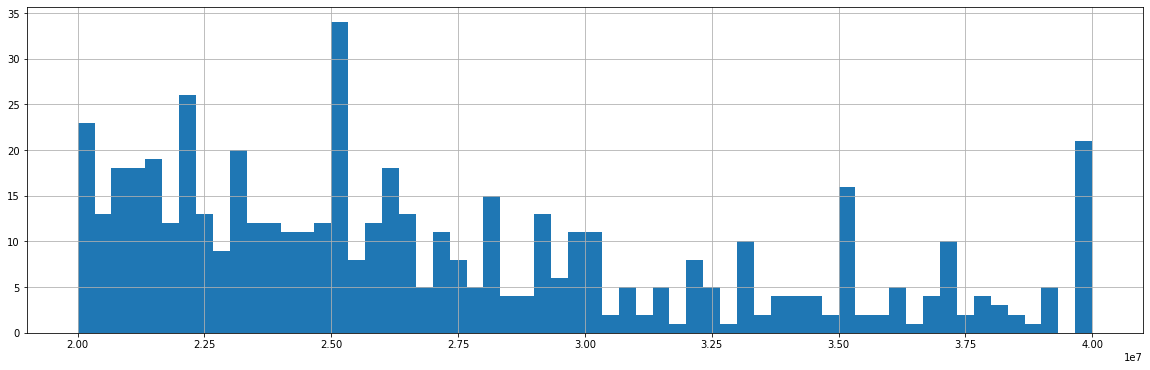

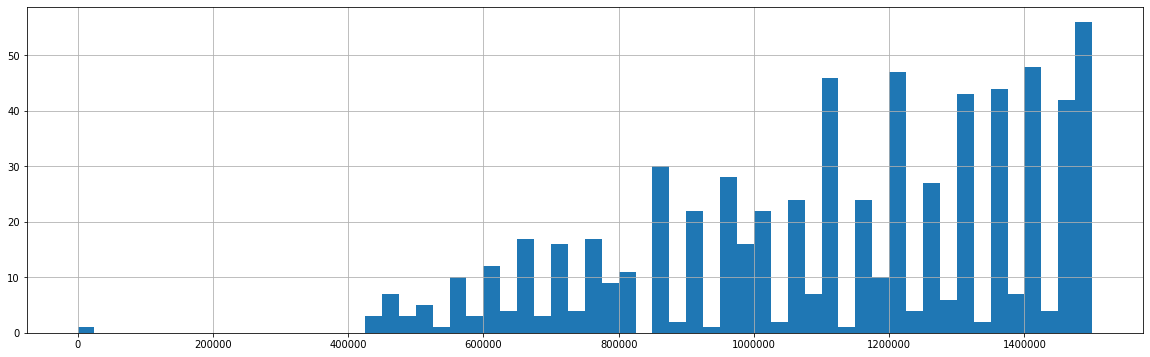

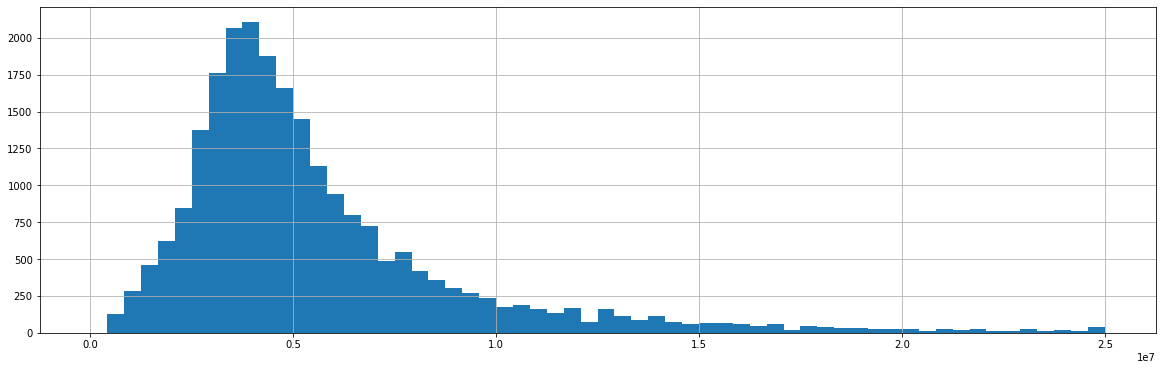

In [8]:
print(data['last_price'].describe())
print(data['last_price'].value_counts())
data['last_price'].hist(bins=60, figsize=(20, 6), range=(20000000, 40000000));
plt.show()
data['last_price'].hist(bins=60, figsize=(20, 6), range=(0, 1500000));
plt.show()
data['last_price'].hist(bins=60, figsize=(20, 6), range=(0, 25000000));

### Вывод

1. Стоимость квартир варьируется от 121 900 рублей до 763 000 000 рублей.
2. Самой популярной стоимостью является 4 500 0000 рублей.
3. Большинство цен находится в диапазоне от 3 400 000 до 6 799 000 рублей с медианой в 4 650 000 рублей.
4. По гистограмме видно, что пик приходится на область от 3 млн. до 4.5 млн, очень мало значений до 1 млн и после 18 млн, есть отдельные выбросы вплоть до 736 млн.

count    23613.000000
mean         2.071147
std          1.078380
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64
1     8015
2     7913
3     5795
4     1177
5      325
0      194
6      104
7       59
8       12
9        8
10       3
14       2
11       2
19       1
12       1
16       1
15       1
Name: rooms, dtype: int64
       open_plan    studio
rooms                     
0       0.304124  0.695876
1       0.000374  0.001372
2       0.000126  0.000000
3       0.000345  0.000000
4       0.000850  0.000000
5       0.003077  0.000000
6       0.000000  0.000000
7       0.000000  0.000000
8       0.000000  0.000000
9       0.000000  0.000000
10      0.000000  0.000000
11      0.000000  0.000000
12      0.000000  0.000000
14      0.000000  0.000000
15      0.000000  0.000000
16      0.000000  0.000000
19      0.000000  0.000000


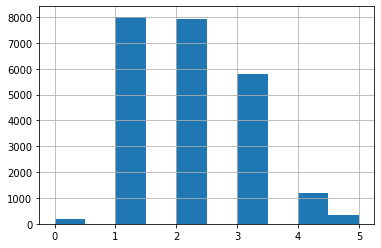

In [9]:
print(data['rooms'].describe())
print(data['rooms'].value_counts())
print(data.pivot_table(index='rooms', values=['studio', 'open_plan']))
data['rooms'].hist(range=(0, 5));
data['rooms'] = data['rooms'].replace(0, 1)


### Вывод

1. Количество комнат варьируется от 0 до 19.
2. Самыми популярными являются однокомнатные  и двухкомнатные квартиры.
3. По гистограмме видно, что пик приходится на область от 1 до 3-х комнат, очень мало квартир с 0 комнат (так указывали владельцы студий и свободных планировок) и после 5, есть отдельные выбросы вплоть до 19 комнат. Для корректных расчетов заменим 0 комнат на 1.

count    23613.000000
mean         2.724581
std          0.990085
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64
2.65      9792
2.50      3515
2.60      1646
2.70      1573
3.00      1111
          ... 
3.98         1
4.65         1
5.80         1
4.90         1
100.00       1
Name: ceiling_height, Length: 183, dtype: int64
       total_images   last_price  total_area first_day_exposition  rooms  \
20264            17  119000000.0       187.6           2017-07-10      4   
3474              3    1400000.0        30.0           2018-03-16      1   
15743            14    5600000.0        67.0           2016-11-11      3   
17442             0    5350000.0        54.0           2015-06-16      2   
5863             20    5650000.0        45.0           2018-08-15      1   
22309            20    5300000.0        45.0           2017-09-30      1   
15061            19    5600000.0        56

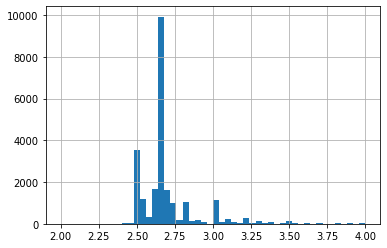

In [10]:
print(data['ceiling_height'].describe())
print(data['ceiling_height'].value_counts())
print(data.query('ceiling_height > 4').sort_values(by = 'ceiling_height').tail(30))
print(data.query('ceiling_height < 2.2').sort_values(by = 'ceiling_height'))
data['ceiling_height'].hist(bins=50, range=(2, 4));

### Вывод

1. Высота потолков варьируется от 1 до 100 м.
2. Большинство квартир имеют высоту потолков от 2.6 до 2.7. Средняя высота составляет 2.65 м.
3. Квартиры с высотой потолков от 1 до 2.2 и от 8 до 100 м являются ошибками, т.к. квартир с потолком ниже 2.2 не существует, а квартиры с потолком выше 8 м стоят недорого согласно данным, что не может быть правдой.
3. По гистограмме видно, что есть 2 максимальных пика 2.5 и 2.65 м, также есть 2 небольших пика - 2.9 и 3 м. Очень мало значений приходится на диапазон от 1 до 2.4 и от 4 до 100 м.

45.0      880
60.0      538
7.0       234
30.0      208
90.0      201
         ... 
1355.0      1
873.0       1
730.0       1
976.0       1
773.0       1
Name: days_exposition, Length: 1139, dtype: int64


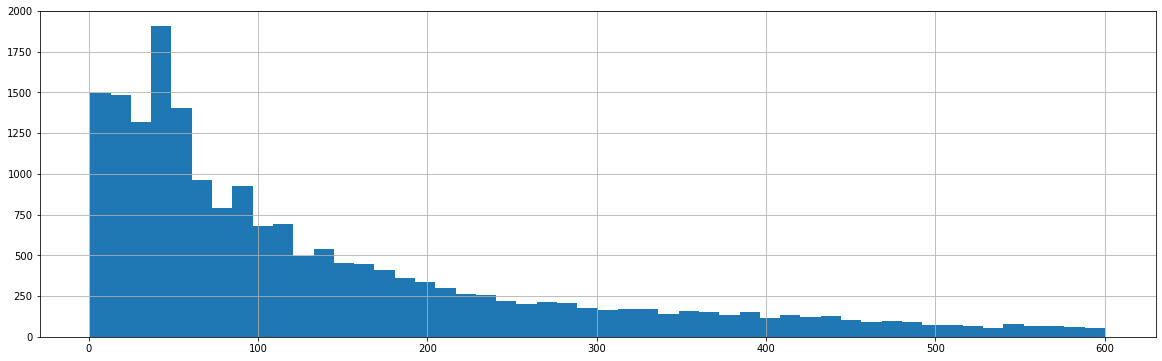

In [11]:
# print(data['days_exposition'].describe())
print(data['days_exposition'].value_counts())
#print(data.query('ceiling_height > 4').sort_values(by = 'ceiling_height').tail(30))
#print(data.query('ceiling_height < 2.2').sort_values(by = 'ceiling_height'))
data['days_exposition'].hist(bins=50, range=(1, 600), figsize=(20, 6));

### Вывод

1. Время продажи квартир варьируется от 1 до 1580 дней. Самой популярной продолжительностью является 45 дней.
2. Среднее составляет 180 дней, медиана - 95 дней.
3. Быстрой продажей квартиры можно считать диапазон от 1 до 30 дней. Необычно долгой продажей - дольше 300 дней.


count    18104.000000
mean     14185.084015
std       8614.132292
min        181.000000
25%       9233.750000
50%      13093.000000
75%      16287.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64
                    total_images  last_price  total_area  \
locality_name                                              
зеленогорск                   24          24          24   
колпино                        4           4           4   
красное село                   8           8           8   
кронштадт                     95          95          95   
ломоносов                    132         132         132   
павловск                       4           4           4   
петергоф                      53          53          53   
посёлок белоостров             1           1           1   
посёлок молодёжное             5           5           5   
посёлок репино                 4           4           4   
посёлок сапёрный               6           6           6   
пу

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m2,weekday,month,year,ratio_living_total,ratio_kitchen_total
count,14889.000000,1.488900e+04,14889.000000,14889.000000,14889.000000,14889.000000,14889.000000,14889.000000,14889.000000,14889.000000,...,6395.000000,14889.000000,7176.000000,13130.000000,14889.000000,14889.000000,14889.000000,14889.000000,14889.000000,14889.000000
mean,10.027470,6.091897e+06,56.747826,2.015313,2.697430,11.907516,32.626054,6.442273,10.103664,0.596212,...,504.513526,0.709987,532.349080,175.547144,107365.046478,2.563033,6.423467,2017.360400,0.566555,0.187004
std,5.644324,2.813550e+06,20.655686,0.913159,0.208574,6.628538,14.306140,5.102500,4.466806,0.959708,...,343.242238,0.891091,278.789375,217.022413,26311.941909,1.784220,3.462230,1.039781,0.101706,0.070058
min,0.000000,1.200000e+06,25.070000,1.000000,2.400000,1.000000,2.000000,1.000000,0.111176,0.000000,...,1.000000,0.000000,13.000000,1.000000,15345.268542,0.000000,1.000000,2014.000000,0.038462,0.004400
25%,6.000000,4.100000e+06,41.000000,1.000000,2.600000,6.000000,19.400000,3.000000,7.000000,0.000000,...,304.000000,0.000000,311.000000,41.000000,89782.244556,1.000000,3.000000,2017.000000,0.500000,0.137876
50%,10.000000,5.250000e+06,52.000000,2.000000,2.650000,10.000000,30.400000,5.000000,9.200000,0.000000,...,469.000000,0.000000,522.000000,91.000000,102586.206897,3.000000,6.000000,2017.000000,0.576271,0.169291
75%,14.000000,7.200000e+06,68.600000,3.000000,2.700000,16.000000,42.000000,9.000000,11.900000,1.000000,...,624.000000,1.000000,751.000000,220.000000,120147.420147,4.000000,10.000000,2018.000000,0.631833,0.228571
max,50.000000,1.790000e+07,124.800000,5.000000,5.800000,52.000000,95.000000,33.000000,60.000000,5.000000,...,3190.000000,3.000000,1344.000000,1553.000000,387096.774194,6.000000,12.000000,2019.000000,0.989315,0.787879


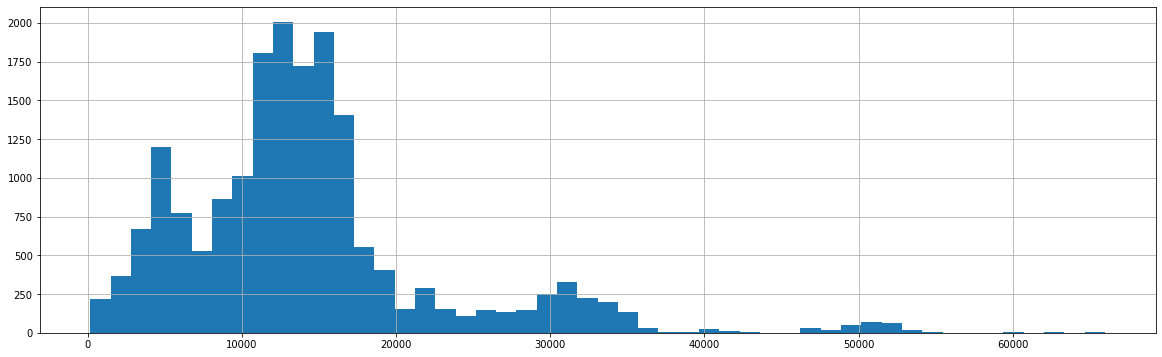

In [12]:
print(data['cityCenters_nearest'].describe())
data['cityCenters_nearest'].hist(bins=50, figsize=(20, 6))
print(data.query('cityCenters_nearest > 35000').groupby('locality_name').count())
data_average = (
    data
    .query('25 < total_area < 125')
    .query('1000000 < last_price < 18000000')
    .query('rooms <= 5')
    .query('2.4 <= ceiling_height <= 6')
    .query('cityCenters_nearest < 25000')
)
print(data_average.info())
data_average.describe()

### Вывод

1. В новый DataFrame 'data_average' включены данные без редких и выбивающихся значений по столбцам общая площадь, цена, количество комнат, высота потолков, а также расстояние до центра.
2. Изучив получившийся DataFrame можно сделать вывод, что медианы столбцов, которые подверглись корректировке, практически остались без изменения.



In [13]:
data_average_corr = data_average[['last_price', 'total_area', 'rooms', 'ceiling_height', 'cityCenters_nearest']]
data_average_corr.corr()

,last_price,total_area,rooms,ceiling_height,cityCenters_nearest
last_price,1.000000,0.804578,0.500830,0.389307,-0.405161
total_area,0.804578,1.000000,0.786312,0.323675,-0.264993
rooms,0.500830,0.786312,1.000000,0.147234,-0.203593
ceiling_height,0.389307,0.323675,0.147234,1.000000,-0.398287
cityCenters_nearest,-0.405161,-0.264993,-0.203593,-0.398287,1.000000


### Вывод

1. Анализ показал, что больше всего стоимость квартиры зависит от площади квартиры. Также имеется большая зависимость от количества комнат. Высота потолков и расстояние до центра не оказывают большого влияния на стоимость квартиры.



In [14]:
data_average.pivot_table(index='grouping_floor', values='last_price', aggfunc=['mean', 'median'])

,mean,median
,last_price,last_price
grouping_floor,,
другой,6.188356e+06,5306202.5
первый,5.321343e+06,4789750.0
последний,6.127523e+06,5150000.0


### Вывод

1. На первом этаже продаются квартиры самые дешевые. Дороже - на последнем этаже. Самые дорогие квартиры - на других этажах



In [15]:
print(data_average.pivot_table(index='weekday', values='last_price', aggfunc=['mean', 'median']))
print(data_average.pivot_table(index='month', values='last_price', aggfunc=['mean', 'median']))
print(data_average.pivot_table(index='year', values='last_price', aggfunc=['mean', 'median']))

                 mean     median
           last_price last_price
weekday                         
0        6.133155e+06  5300000.0
1        6.159874e+06  5250000.0
2        6.113635e+06  5272500.0
3        6.134930e+06  5250000.0
4        5.985666e+06  5200000.0
5        6.026185e+06  5200000.0
6        6.001164e+06  5200000.0
               mean     median
         last_price last_price
month                         
1      6.213438e+06  5380000.0
2      6.033120e+06  5200000.0
3      6.156657e+06  5350000.0
4      6.217938e+06  5302405.0
5      5.998862e+06  5150000.0
6      5.891011e+06  5000000.0
7      5.917820e+06  5100000.0
8      6.037265e+06  5200000.0
9      6.311656e+06  5300000.0
10     5.997275e+06  5100000.0
11     6.076515e+06  5200000.0
12     6.210630e+06  5500000.0
              mean     median
        last_price last_price
year                         
2014  8.762853e+06  8118500.0
2015  6.640283e+06  5700000.0
2016  5.998814e+06  5100000.0
2017  5.910093e+06  50000

### Вывод

1. На стоимость квартиры не влияет день подачи объявления.
2. В апреле и в декабре цены на квартиры самие высокие. В мае и июне - самые низкие.
3. Самые высокие цены на квартиры были в 2014 году. Далее пошел спад рынка недвижимости. Рост начался только в 2018 году и в 2019 достиг уровня 2015 года.



In [16]:
locality_name = data_average.pivot_table(index='locality_name', values=['last_price', 'price_m2'], aggfunc=['count', 'median'])
locality_name.columns = ['price_count', 'price_m2_count', 'price_median', 'price_m2_median']
top_10 = (
    locality_name
    .sort_values(by = 'price_count', ascending = False)
    .head(10)
    .sort_values(by = 'price_median', ascending = False)
)

top_10


,price_count,price_m2_count,price_median,price_m2_median
locality_name,,,,
санкт-петербург,14220,14220,5300000.0,103402.076319
пушкин,20,20,4975000.0,98628.952569
посёлок парголово,325,325,4100000.0,91917.591125
посёлок стрельна,41,41,3900000.0,87741.935484
посёлок шушары,247,247,3850000.0,78688.524590


### Вывод

1. Выведены 10 населенных пунктов с наибольшим числом объявлений.
2. Среди них, самая высокая средняя стоимость жилья оказалась в Санкт-Петербурге, а самая низкая - в поселке Шушары.


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,price_m2,weekday,month,year,grouping_floor,ratio_living_total,ratio_kitchen_total,cityCenters_km


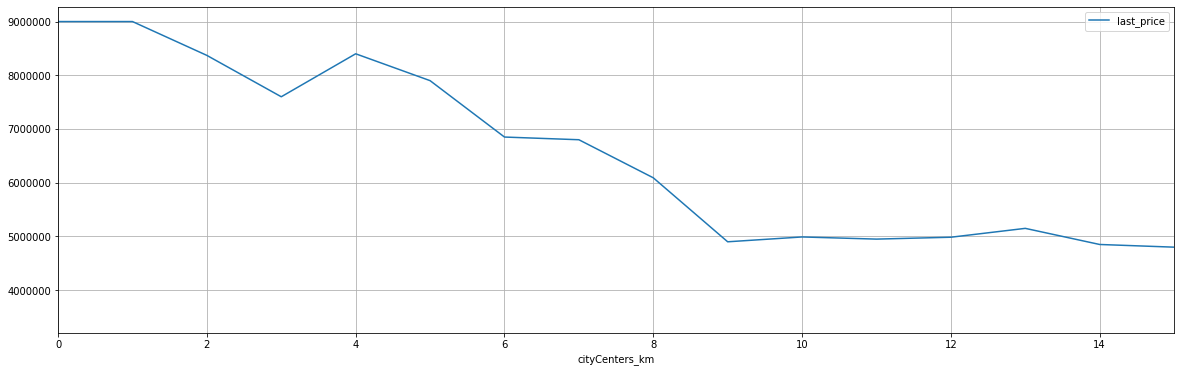

In [17]:
leningrad = data_average.query('locality_name == "санкт-петербург"').copy()
#leningrad.dropna(subset = ['cityCenters_nearest'], inplace = True)
leningrad['cityCenters_km'] = (leningrad['cityCenters_nearest'] / 1000).astype('int')
price_per_km = leningrad.pivot_table(index='cityCenters_km', values='last_price', aggfunc='median')
price_per_km.plot(grid=True, xlim=(0, 15), figsize=(20, 6))
#price_per_km.query('cityCenters_km > 25')
leningrad.query('cityCenters_km == 27')

### Вывод

1. Исходя из графика зависимости цены от расстояния до центра города, следует что центром можно назвать окружность радиусом 9 км.


In [18]:
leningrad_center = leningrad.query('cityCenters_km <= 9').copy()
print(leningrad_center['total_area'].describe())
print(leningrad_center['total_area'].value_counts())
print(leningrad_center['last_price'].describe())
print(leningrad_center['last_price'].value_counts())
print(leningrad_center['rooms'].describe())
print(leningrad_center['rooms'].value_counts())
print(leningrad_center['ceiling_height'].describe())
print(leningrad_center['ceiling_height'].value_counts())

count    4043.000000
mean       65.792471
std        23.282912
min        25.200000
25%        46.000000
50%        63.000000
75%        82.175000
max       124.800000
Name: total_area, dtype: float64
60.00     62
43.00     57
45.00     56
31.00     53
42.00     52
          ..
69.75      1
29.50      1
108.50     1
27.50      1
49.30      1
Name: total_area, Length: 892, dtype: int64
count    4.043000e+03
mean     7.811926e+06
std      3.267179e+06
min      1.600000e+06
25%      5.300000e+06
50%      7.200000e+06
75%      9.608300e+06
max      1.790000e+07
Name: last_price, dtype: float64
8500000.0    63
7500000.0    63
6500000.0    55
8000000.0    50
9000000.0    40
             ..
9999870.0     1
3990900.0     1
8820000.0     1
7995000.0     1
8585256.0     1
Name: last_price, Length: 1024, dtype: int64
count    4043.000000
mean        2.279990
std         0.959219
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: rooms, d

### Вывод

1. Площадь квартиры. Самая популярная площадь - 60 м2. Медиана - 63 м2.
2. Цена. Самая популярная площадь - 8,5 млн. Медиана - 7,2 млн.
3. Количество комнат. Самыми популярными и медианой являются 2-х комнатные квартиры.
4. Высота потолков. Самая популярная - 2,65 м. Медиана - 2,7 м.


In [19]:
leningrad_center_corr = leningrad_center[['last_price', 'total_area', 'rooms', 'ceiling_height', 'cityCenters_nearest']]
leningrad_center_corr.corr()

,last_price,total_area,rooms,ceiling_height,cityCenters_nearest
last_price,1.000000,0.749954,0.456823,0.272239,-0.314220
total_area,0.749954,1.000000,0.786453,0.292400,-0.317162
rooms,0.456823,0.786453,1.000000,0.212428,-0.252425
ceiling_height,0.272239,0.292400,0.212428,1.000000,-0.349298
cityCenters_nearest,-0.314220,-0.317162,-0.252425,-0.349298,1.000000


### Вывод

1. Анализ показал, что больше всего стоимость квартиры зависит от площади квартиры. Также имеется небольшая зависимость от количества комнат. Высота потолков и расстояние до центра не оказывают большого влияния на стоимость квартиры.
2. Влияние факторов по сравнению с общим анализом уменьшилось.



In [20]:
leningrad_center.pivot_table(index='grouping_floor', values='last_price', aggfunc=['mean', 'median'])

,mean,median
,last_price,last_price
grouping_floor,,
другой,8.023069e+06,7500000.0
первый,6.461649e+06,5900000.0
последний,7.833686e+06,7300000.0


### Вывод

1. На первом этаже продаются квартиры самые дешевые. Дороже - на последнем этаже. Самые дорогие квартиры - на других этажах.
2. Закономерность идентична общему анализу, только средняя цена увеличилась на 2 млн.



In [21]:
print(leningrad_center.pivot_table(index='weekday', values='last_price', aggfunc=['mean', 'median']))
print(leningrad_center.pivot_table(index='month', values='last_price', aggfunc=['mean', 'median']))
print(leningrad_center.pivot_table(index='year', values='last_price', aggfunc=['mean', 'median']))

                 mean     median
           last_price last_price
weekday                         
0        7.993091e+06  7380000.0
1        7.783647e+06  7100000.0
2        7.988409e+06  7400000.0
3        7.728820e+06  7000000.0
4        7.679292e+06  7100000.0
5        7.590572e+06  7070434.0
6        7.870468e+06  7525000.0
               mean     median
         last_price last_price
month                         
1      7.838004e+06  7130000.0
2      7.558576e+06  6835000.0
3      7.919800e+06  7300000.0
4      7.797059e+06  7350000.0
5      7.505610e+06  6990000.0
6      7.552404e+06  6980000.0
7      7.683990e+06  7300000.0
8      8.122471e+06  7375000.0
9      8.335071e+06  7800000.0
10     7.690810e+06  6950000.0
11     8.063045e+06  7407105.0
12     7.534677e+06  6800000.0
              mean     median
        last_price last_price
year                         
2014  9.112392e+06  8792628.0
2015  8.224593e+06  7585000.0
2016  7.816215e+06  7100000.0
2017  7.777723e+06  71000

### Вывод

1. На стоимость квартиры не влияет день подачи объявления.
2. В сентябре цены на квартиры самие высокие. В феврале и декабре - самые низкие.
3. Самые высокие цены на квартиры были в 2014 году. Далее пошел спад рынка недвижимости. Рост начался только в 2018 году и в 2019 достиг уровня 2015 года.
4. Зависимости в целом сходяться с общим анализом. Отличается зависимость от месяца.


### Шаг 5. Общий вывод

Изучив данные недвижимости Санкт-Петербурга и окрестностей можно сделать вывод, что все рассмотренные факторы влияют на стоимость квартиры: площадь, количество комнат, высота потолков, расстояние до центра, этажность. Но каждый фактор влияет в разной степени. Максимальное влияние оказывает конечно площадь квартиры и количество комнат, этажность. Самый дорогой район - центр Санкт-Петербурга имеет такие же зависимости, что и вся рассматриваемая область.